In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, joblib, statistics
import sklearn as sk
import optuna
import xgboost as xgb
import plotly
import json
import math
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, datasets
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GroupKFold
from typing import List, Optional, Tuple
import functions
from tabulate import tabulate

random.seed(1213870)

### LOADING IN ALL DATASETS AND PREPARING THEM

In [8]:
# data for model training 
path1 = ('../data/Preprop_data_w_folds')

data_MatchingGame = pd.read_csv(os.path.join(path1,'MatchingGame_w_5folds.csv'), delimiter=';')
data_Questions_fam = pd.read_csv(os.path.join(path1, 'Questions_fam_w_5folds.csv'), delimiter=';')
data_Questions_unfam = pd.read_csv(os.path.join(path1, 'Questions_unfam_w_5folds.csv'), delimiter=';')



In [9]:
# data for model testing
path2 = ('../data/test_sets')

MG_MG_20 = pd.read_csv(os.path.join(path2,'MG/test_MatchingGame_20.csv'), delimiter=';')
MG_Qfam_20 = pd.read_csv(os.path.join(path2,'MG/test_Questions_fam_20.csv'), delimiter=';')
MG_Qfam_80 = pd.read_csv(os.path.join(path2,'MG/test_Questions_fam_80.csv'), delimiter=';')
Qfam_MG_20 = pd.read_csv(os.path.join(path2,'Qfam/test_MatchingGame_20.csv'), delimiter=';')
Qfam_MG_80 = pd.read_csv(os.path.join(path2,'Qfam/test_MatchingGame_80.csv'), delimiter=';')
Qfam_Qfam_20 = pd.read_csv(os.path.join(path2,'Qfam/test_Questions_fam_20.csv'), delimiter=';')
Qfam_Qunfam_20 = pd.read_csv(os.path.join(path2,'Qfam/test_Questions_unfam_20.csv'), delimiter=';')
Qfam_Qunfam_80 = pd.read_csv(os.path.join(path2,'Qfam/test_Questions_unfam_80.csv'), delimiter=';')
Qunfam_Qfam_20 = pd.read_csv(os.path.join(path2,'Qunfam/test_Questions_fam_20.csv'), delimiter=';')
Qunfam_Qfam_80 = pd.read_csv(os.path.join(path2,'Qunfam/test_Questions_fam_80.csv'), delimiter=';')
Qunfam_Qunfam_20 = pd.read_csv(os.path.join(path2,'Qunfam/test_Questions_unfam_20.csv'), delimiter=';')


In [10]:
# loading the feature lists
path3 = ('../data/feature_lists')

MG_features = pd.read_csv(os.path.join(path3,'MatchingGame_5fold_featurelist.csv'), delimiter=';')
Qfam_features = pd.read_csv(os.path.join(path3, 'Questions_fam_5fold_featurelist.csv'), delimiter=';')
Qunfam_features = pd.read_csv(os.path.join(path3, 'Questions_unfam_5fold_featurelist.csv'), delimiter=';')

# XGB

### Matching Game

In [ ]:
# HYPERPARAMETERTUNING
bestparams_MG = functions.parametertuner(
    train = data_MatchingGame, 
    feature_lists = MG_features, 
    train_name = 'MatchingGame', 
    trials = 100, 
    jobs = 16)

In [12]:
# loading in best params
#bestparams_MG = functions.extract_bestparams('MatchingGame')

In [ ]:
# Training:

MG_training = functions.modeltraining(train = data_MatchingGame,
             feature_lists = MG_features,
             bestparams = bestparams_MG,
             train_name = 'MatchingGame',
             save = True)

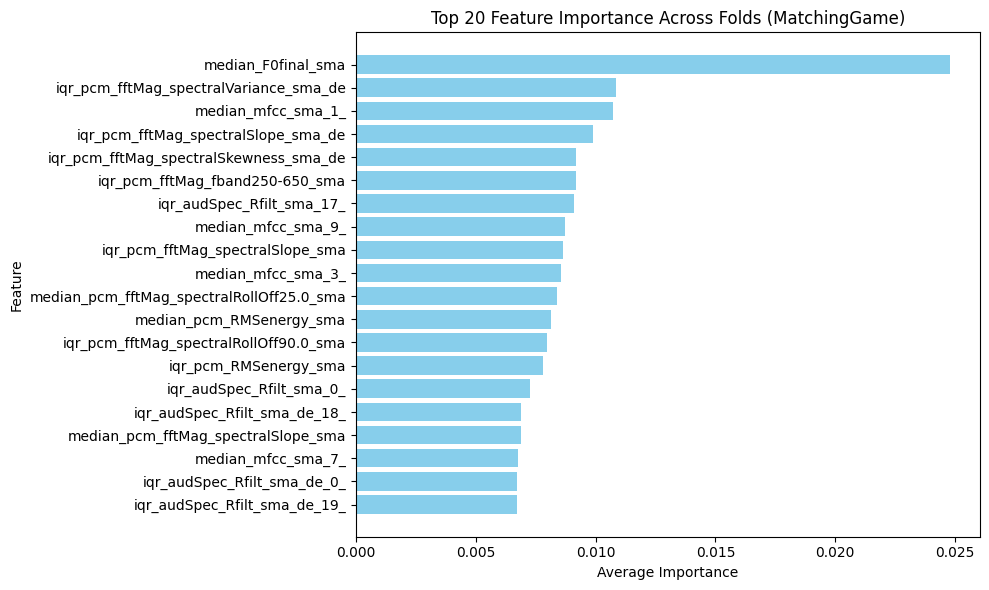

,Feature,Importance
129,median_F0final_sma,0.024801
122,iqr_pcm_fftMag_spectralVariance_sma_de,0.010864
198,median_mfcc_sma_1_,0.010720
120,iqr_pcm_fftMag_spectralSlope_sma_de,0.009898
118,iqr_pcm_fftMag_spectralSkewness_sma_de,0.009178
95,iqr_pcm_fftMag_fband250-650_sma,0.009161
10,iqr_audSpec_Rfilt_sma_17_,0.009084
206,median_mfcc_sma_9_,0.008707
119,iqr_pcm_fftMag_spectralSlope_sma,0.008647
200,median_mfcc_sma_3_,0.008555


In [27]:
# extracting feature importance 
#functions.feature_importance('MatchingGame', MG_features, save = True)

In [15]:
# Testing:

MG_MG_20_test = functions.modeltesting(
    feature_lists=MG_features,
    test=MG_MG_20,
    save=True,
    test_name="MG_MG_20",
    train_name='MatchingGame'
)

MG_Qfam_80_test = functions.modeltesting(
    feature_lists=MG_features,
    test=MG_Qfam_80,
    save=True,
    test_name="MG_Qfam_80",
    train_name='MatchingGame'
)

MG_Qfam_20_test = functions.modeltesting(
    feature_lists=MG_features,
    test=MG_Qfam_20,
    save=True,
    test_name="MG_Qfam_20",
    train_name='MatchingGame'
)

### Convo with Caregiver

In [ ]:
# PARAMETERTUNING

bestparams_Qfam = functions.parametertuner(
    train = data_Questions_fam, 
    feature_lists = Qfam_features,
    train_name = 'Q_fam', 
    trials = 100, 
    jobs = 16)

In [30]:
#loading in best params
#bestparams_Qfam = functions.extract_bestparams('Q_fam')

In [ ]:
# training
Qfam_training = functions.modeltraining(train = data_Questions_fam,
             feature_lists = Qfam_features,
             bestparams = bestparams_Qfam,
             train_name ='Qfam',
             save = True)

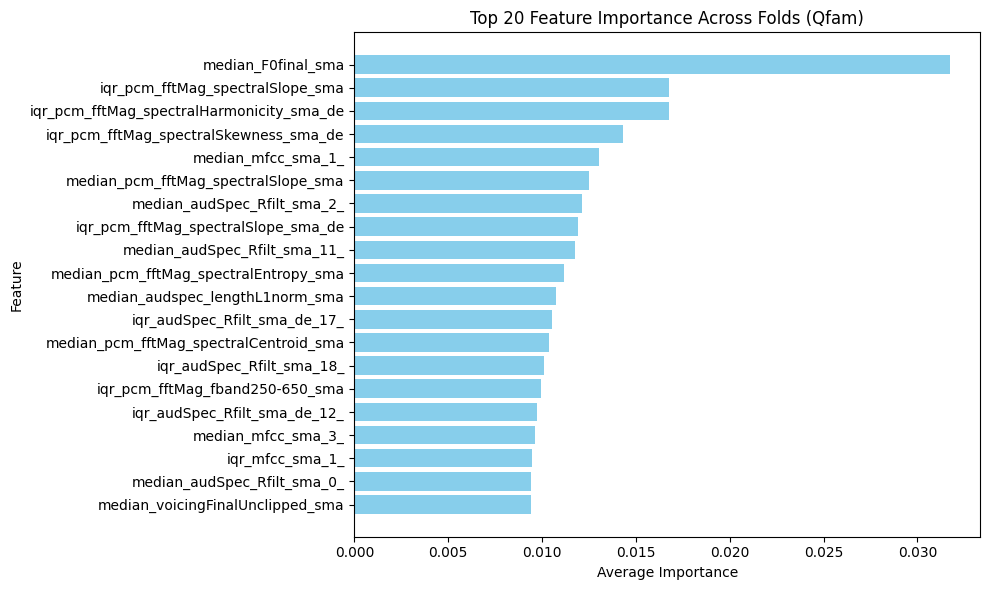

,Feature,Importance
127,median_F0final_sma,0.031745
117,iqr_pcm_fftMag_spectralSlope_sma,0.016759
104,iqr_pcm_fftMag_spectralHarmonicity_sma_de,0.016743
116,iqr_pcm_fftMag_spectralSkewness_sma_de,0.014288
191,median_mfcc_sma_1_,0.013033
242,median_pcm_fftMag_spectralSlope_sma,0.012512
146,median_audSpec_Rfilt_sma_2_,0.012129
118,iqr_pcm_fftMag_spectralSlope_sma_de,0.011934
131,median_audSpec_Rfilt_sma_11_,0.011769
224,median_pcm_fftMag_spectralEntropy_sma,0.011167


In [32]:
# feature importance analysis
#functions.feature_importance('Qfam', Qfam_features, save = True)

In [19]:
# Testing:

Qfam_qfam_20_test = functions.modeltesting(
            Qfam_features,
            Qfam_Qfam_20,
            save = True,
            test_name = "Qfam_Qfam_20",
            train_name = 'Qfam')

Qfam_MG_80_test = functions.modeltesting(
            Qfam_features,
            Qfam_MG_80,
            save = True,
            test_name = "Qfam_MG_80",
            train_name = 'Qfam')

Qfam_MG_20_test = functions.modeltesting(
            Qfam_features,
            Qfam_MG_20,
            save = True,
            test_name = "Qfam_MG_20",
            train_name = 'Qfam')

Qfam_Qunfam_20_test = functions.modeltesting(
            Qfam_features,
            Qfam_Qunfam_20,
            save = True,
            test_name = "Qfam_Qunfam_20",
            train_name = 'Qfam')

Qfam_Qunfam_80_test = functions.modeltesting(
            Qfam_features,
            Qfam_Qunfam_80,
            save = True,
            test_name = "Qfam_Qunfam_80",
            train_name = 'Qfam')

### Convo With Experimenter

In [ ]:
# PARAMETERTUNING

bestparams_Qunfam = functions.parametertuner(
    train = data_Questions_unfam, 
    feature_lists = Qunfam_features,
    train_name = 'Q_unfam', 
    trials = 100, 
    jobs = 16)

In [35]:
# loading in best params
#bestparams_Qunfam = functions.extract_bestparams('Q_unfam')

In [23]:
#Training
Qunfam_training = functions.modeltraining(train = data_Questions_unfam,
             feature_lists = Qunfam_features,
             bestparams = bestparams_Qunfam,
             train_name = 'Qunfam',
             save = True)

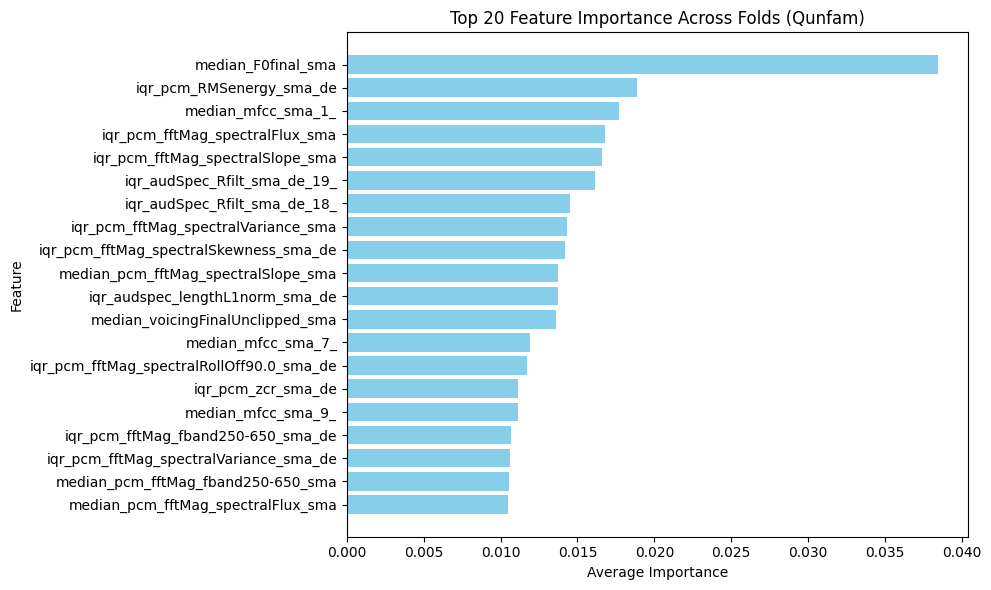

,Feature,Importance
127,median_F0final_sma,0.038474
91,iqr_pcm_RMSenergy_sma_de,0.018900
195,median_mfcc_sma_1_,0.017703
102,iqr_pcm_fftMag_spectralFlux_sma,0.016815
118,iqr_pcm_fftMag_spectralSlope_sma,0.016611
38,iqr_audSpec_Rfilt_sma_de_19_,0.016163
37,iqr_audSpec_Rfilt_sma_de_18_,0.014509
120,iqr_pcm_fftMag_spectralVariance_sma,0.014309
117,iqr_pcm_fftMag_spectralSkewness_sma_de,0.014200
245,median_pcm_fftMag_spectralSlope_sma,0.013738


In [37]:
# feature importance analysis
#functions.feature_importance('Qunfam', Qunfam_features, save = True)

In [ ]:
# Testing:
Qunfam_qunfam_20_test = functions.modeltesting(
            Qunfam_features,
            Qunfam_Qunfam_20,
            save = True,
            test_name = "Qunfam_Qunfam_20",
            train_name = 'Qunfam')

Qunfam_Qfam_80_test = functions.modeltesting(
            Qunfam_features,
            Qunfam_Qfam_80,
            save = True,
            test_name = "Qunfam_Qfam_80",
            train_name = 'Qunfam')

Qunfam_Q_fam_20_test = functions.modeltesting(
            Qunfam_features,
            Qunfam_Qfam_20,
            save = True,
            test_name = "Qunfam_Qfam_20",
            train_name = 'Qunfam')